# Pedotransfer Functions

Understanding and qunatifying the storage and transport of water, heat, and solutes in the soil requires detailed knowledge of the soil physical properties. Soil physical properties such as soil textural class and bulk density are easy to measure, while others such as saturated hydraulic conductivity and the energy-state of the soil water are more time consuming and require specialized equipment. Because of the inherent connection between particle size and many of the soil hydraulic and thermal properties, scientists have developed correlations between easy-to-measure properties and difficult-to-measure properties. These empirical correlations are known as "pedotransfer functions".

One of the most widely known and practical set of pedotransfer functions was developed by Saxton and Rawls in 1986 and refined in 2006.


In [8]:
# Import modules
import numpy as np
import pandas as pd


In [46]:
def ptf(clay, sand, om=0.02, ec=0, rho=np.nan):
    """ 
    Set of pedotransfer functions to determine soil physical properties from 
    soil texture information and organic matter.

    Inputs: clay, sand, and organic matter (om) represented as a fraction. Values range between 0 and 1.

    Outputs: S is a dictionary containing scalar values.
             V is a Pandas dataframe containing vector values across the range from 1500 to 0 kPa.

    """ 


    # Section numbering does NOT follow the Saxton and Rawls paper
    # 1. Permanent wilting point
    # Calculation of soil water retention at -1500 kPa of tension (Table 1. Eq. 1)
    theta_1500t = -0.024*sand + 0.487*clay + 0.006*om + 0.005*(sand*om) - 0.013*(clay*om) + 0.068*(sand*clay) + 0.031 
    theta_1500 = theta_1500t + (0.14*theta_1500t - 0.02)

    # 2. Field capacity
    # Calculation of soil water retention at -33 kPa of tension (Table 1. Eq. 2)
    theta_33t= -0.251*sand + 0.195*clay + 0.011*om + 0.006*(sand*om) - 0.027*(clay*om) + 0.452*(sand*clay) + 0.299
    theta_33 = theta_33t + 1.283*(theta_33t)**2 - 0.374*(theta_33t) - 0.015

    # 3. Saturation-Field capacity.
    # Volumetric soil water content between 0 and -33 kPa of tension (Table 1. Eq. 3). 
    thetaS_33t= 0.278*sand + 0.034*clay + 0.022*om - 0.018*(sand*om) - 0.027*(clay*om) - 0.584*(sand*clay) + 0.078
    thetaS_33= thetaS_33t + (0.636*thetaS_33t - 0.107)

    # 4. Tension at air entry suction.
    # Estimation of the tension at air entry (Table 1. Eq. 4).
    psi_et = -21.67*sand - 27.93*clay - 81.97*thetaS_33 + 71.12*sand*thetaS_33 + 8.29*clay*thetaS_33 + 14.05*sand*clay + 27.16
    psi_e = max(psi_et + 0.02*psi_et**2 - 0.113*psi_et - 0.7,0.1); # A minimum air-entry suction of 1 kPa was assumed to avoid negative values in sandy soils. 

    # 5. Saturation.
    # Calculation of soil water retention at -0 kPa of tension (Table 1. Eq. 5)
    thetaS = theta_33 + thetaS_33 - 0.097*sand + 0.043 # Saturation at normal density

    # 6. Density effects (allow user to input of bulk density in case is known)
    if ~np.isnan(rho):
        rho_DF = rho
    else:
        rho_N = (1-thetaS)*2.65 # Particle density is assumed to be 2.65 g cm^-3. (Table 1. Eq. 6)
        DF = 1 # Compaction degree.
        rho_DF = rho_N*DF # (Table 1. Eq. 7).

    thetaS_DF = 1 - (rho_DF/2.65) # (Table 1. Eq. 8).
    theta_33_DF = theta_33 - 0.2*(thetaS-thetaS_DF) # (Table 1. Eq. 9).
    thetaS_33_DF = thetaS_DF - theta_33_DF; # (Table 1. Eq. 10).
    # thetaS_33_DF is used with equations that account for gravel, not present
    # in this version. For more information see Table 1 Eqs. 19-22 in Saxton and Rawls, 2006.

    # 7. Moisture tension
    B = (np.log(1500) - np.log(33))/(np.log(theta_33) - np.log(theta_1500)) # (Table 1. Eq. 15).
    A = np.exp(np.log(33) + B*np.log(theta_33)); # (Table 1. Eq. 14).

    # Generate points of volumetric water content.
    theta_piece1 = np.linspace(theta_1500, theta_33_DF, 1000) # theta from theta_1500 to theta_33
    theta_piece2 = np.linspace(theta_33_DF, thetaS_DF, 1000) # theta from theta_33 to theta_0

    # Generate soil matric potential values
    psi_piece1 = A*theta_piece1**(-B) # Matric potential from 1500 to 33 kPa (Table 1. Eq. 11). 
    psi_piece2 = 33 - ((theta_piece2 - theta_33)*(33 - psi_e)/(thetaS_DF - theta_33)) # Matric potential from 33 kPa to air-entry suction (Table 1. Eq. 12).

    # Merge water content and matric potential pieces to generate the soil water retention curve
    theta = np.concatenate((theta_piece1, theta_piece2, [thetaS_DF]))
    psi_m = np.concatenate((psi_piece1, psi_piece2, [0.1]))

    # 8. Calculate volumetric water content at 10 kPa (perhaps a better definition of field capacity)
    psi_diff10 = (psi_m - 10)**2;
    theta_10_DF = theta[psi_diff10.argmin(axis=0)]

    # 9. Moisture conductivity
    par_lambda = 1/B; # (Table 1. Eq. 18).
    Ks = 1930*(thetaS_DF - theta_33)**(3 - par_lambda) # (Table 1. Eq. 16) in [mm/h].
    K_theta = Ks*(theta/thetaS_DF)**(3 + (2/par_lambda)) # (Table 1. Eq. 17).

    # 10. Salinity effects
    psi_o = 36*ec # (Table 1. Eq. 23).
    psi_o_theta = thetaS/theta*psi_o # (Table 1. Eq. 24).

    # 11. Set outputs
    S = dict([('theta_sat',thetaS_DF), 
              ('theta_10',theta_10_DF), 
              ('theta_33',theta_33_DF), 
              ('theta_1500',theta_1500), 
              ('K_sat',Ks), 
              ('psi_o',psi_o), 
              ('rho',rho_DF)])

    V = pd.DataFrame(np.transpose([theta, psi_m, psi_o_theta, K_theta]))
    V.columns = ['theta', 'psi_m', 'psi_o', 'K_theta']

    return S,V 



In [52]:
# Example inputs
clay = 0.34 # 34% clay
sand = 0.22 # 22% sand
om = 0.015  # 1.5% OM

# Call function
S,V = ptf(clay, sand, om, ec)

# Optional call if electrical conductivity and bulk density are known
# S,V = ptf(clay, sand, om, ec, rho=1.5)
# ec = 0.075  # 0.075 dS/m
# rho=1.5 # g/cm^3
# S,V = ptf(clay, sand, om, ec=ec, rho=rho)

print(S)
V.tail()

{'theta_sat': 0.4339622641509434, 'theta_10': 0.43279196976870016, 'theta_33': 0.3504534007323006, 'theta_1500': 0.20392632400000002, 'K_sat': 1.5160753706941434, 'psi_o': 2.6999999999999997, 'rho': 1.5}


,theta,psi_m,psi_o,K_theta
1996,0.433711,9.740105,2.751992,1.501269
1997,0.433795,9.716288,2.751462,1.506189
1998,0.433879,9.692471,2.750932,1.511125
1999,0.433962,9.668654,2.750402,1.516075
2000,0.433962,0.100000,2.750402,1.516075


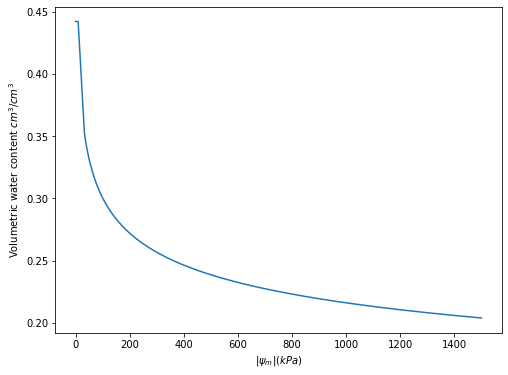

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(V["psi_m"],V["theta"])
plt.xlabel("$|\psi_m| (kPa)$")
plt.ylabel("Volumetric water content $cm^3/cm^3$")
plt.show()

## References

Rawls, W.J., Brakensiek, D.L. and Saxtonn, K.E., 1982. Estimation of soil water properties. Transactions of the ASAE, 25(5), pp.1316-1320.
           
Saxton, K.E., Rawls, W., Romberger, J.S. and Papendick, R.I., 1986. Estimating generalized soil-water characteristics from texture 1. Soil science society of America Journal, 50(4), pp.1031-1036.

Saxton, K.E. and Rawls, W.J., 2006. Soil water characteristic estimates by texture and organic matter for hydrologic solutions. Soil science society of America Journal, 70(5), pp.1569-1578.